
## Print figures of Himawari SST data in regions (distributed)


In [1]:
import os, sys, shutil
from glob import glob
#
%matplotlib inline
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask import compute, delayed
# 
from datetime import datetime
import pandas as pd
#
from hw.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


satpy not available


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# launch cluster and workers

# folder where data is spilled when RAM is filled up
#local_dir = os.getenv('HOME')+'/dask_scratch/'
#local_dir = os.getenv('SCRATCH')+'/dask_scratch/'
#local_dir = os.getenv('DATAWORK')+'/dask_scratch/'
local_dir = os.getenv('TMPDIR')
#
cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                     threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                     death_timeout=100)


In [3]:
cluster.start_workers(4)

[2, 3, 4, 5]

In [10]:
cluster.scheduler

<Scheduler: "tcp://10.148.1.112:43263" processes: 8 cores: 112>

In [11]:
### get dask handles and check dask server status
client = Client(cluster)

In [12]:
client

Client Scheduler: tcp://10.148.1.112:43263 Dashboard: http://10.148.1.112:8787/status,Cluster Workers: 8 Cores: 112 Memory: 400.00 GB


In [13]:
# data path
region = 'NWA'; vmin = 20.; vmax = 35.
region = 'NWAM'; vmin = 26.; vmax = 32.
region = 'WA'; t1, t2, suff, vmin, vmax, slat, slon = datetime(2016,9,3), datetime(2016,9,16), '_t1z', 23., 30., slice(-12,-24), slice(108,126)

#
dpath = '/home/datawork-lops-osi/data/hw/sst/'+region+'/';
#figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+region+'_*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
#filenames = filenames[:-1]

# consider a time subset
times = [datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc') for f in filenames]
if 't1' in locals() and 't2' in locals():
    filenames  = [f for f,t in zip(filenames,times) if (t>t1) and (t<t2)]
print('Number of files processed: %d' %len(filenames))

Number of files available: 54866
Number of files processed: 1842


In [14]:
# open files
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')

# spatial zoom
if 'slat' in locals():
    ds = ds.sel(lat=slat)

# sst in degC
ds['sea_surface_temperature'] += -273.15
ds['sea_surface_temperature'] = ds['sea_surface_temperature'].where(ds['sea_surface_temperature']>0)

print('SST dataset size: %.1f GB' %(ds['sea_surface_temperature'].nbytes/1e9))

CPU times: user 33.1 s, sys: 2.71 s, total: 35.8 s
Wall time: 1min 18s
SST dataset size: 4.4 GB


In [15]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 601, lon: 1001, time: 1842)
Coordinates:
  * lat                      (lat) float32 -12.0 -12.019997 -12.040001 ...
  * lon                      (lon) float32 105.0 105.02 105.04 105.06 105.08 ...
  * time                     (time) datetime64[ns] 2016-09-03T00:10:17 ...
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    wind_speed               (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    solar_zenith_angle       (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    title:                      Sea Surface Temperature from AHI onboard Hima...
    summary:                    TBD
    references:                 TBD
    institution:                Japan Aerospace Exploration Agency(JAXA)
  

---

# mean quantities

In [16]:
Tmean_xt = ds['sea_surface_temperature'].mean(['lon','time']).persist()

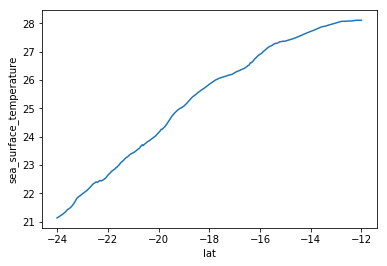

In [17]:
Tmean_xt.plot()

In [18]:
Tmean_xt

<xarray.DataArray 'sea_surface_temperature' (lat: 601)>
dask.array<shape=(601,), dtype=float32, chunksize=(601,)>
Coordinates:
  * lat      (lat) float32 -12.0 -12.019997 -12.040001 -12.059998 -12.080002 ...

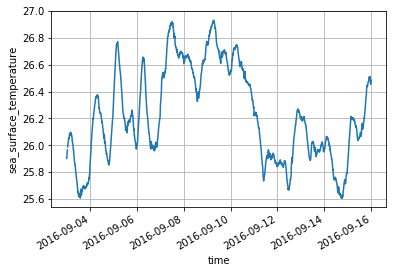

In [19]:
Tmean_xy = ds['sea_surface_temperature'].mean(dim=['lon','lat'])
Tmean_xy.plot()
plt.grid()

In [20]:
Tmean_t = ds['sea_surface_temperature'].mean('time').persist()

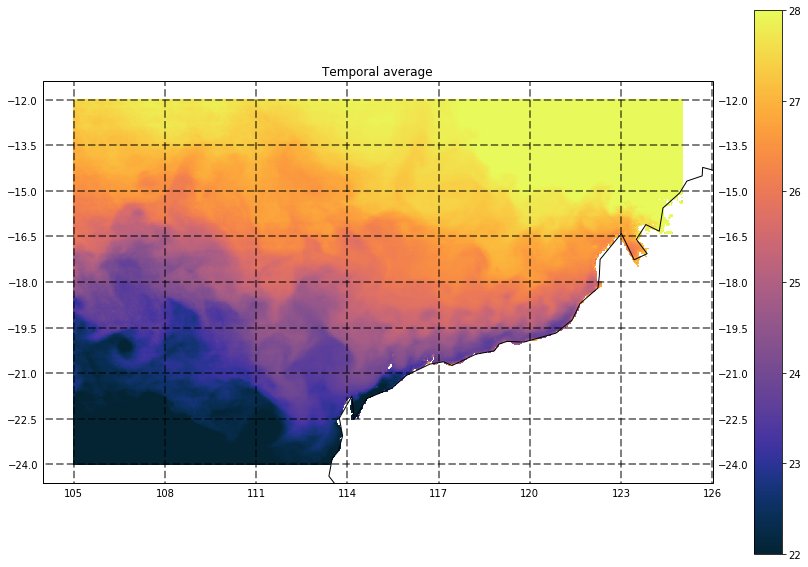

In [21]:
plot_sst(Tmean_t, title='Temporal average', vmin=22., vmax=28., figsize=(15,10))

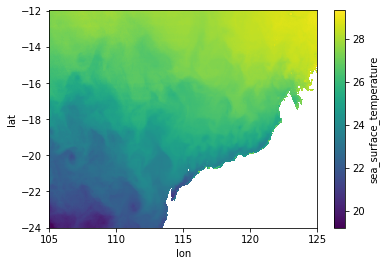

In [22]:
Tmean_t.plot()

---

# diurnal cycle

In [23]:
Tdcycle = (ds['sea_surface_temperature'].mean('lon') - Tmean_xt).groupby('time.hour').mean('time')
Tdcycle = Tdcycle.persist()

In [24]:
Tdcycle

<xarray.DataArray 'sea_surface_temperature' (hour: 24, lat: 601)>
dask.array<shape=(24, 601), dtype=float32, chunksize=(1, 601)>
Coordinates:
  * lat      (lat) float32 -12.0 -12.019997 -12.040001 -12.059998 -12.080002 ...
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

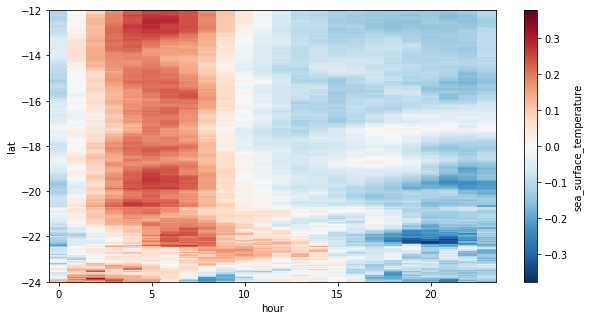

In [25]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
Tdcycle.T.plot(ax=ax)

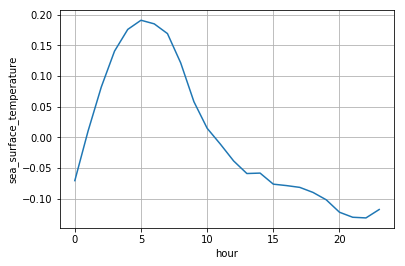

In [26]:
Tdcycle.mean('lat').plot()
plt.grid()

---

# zonally averaged temperature

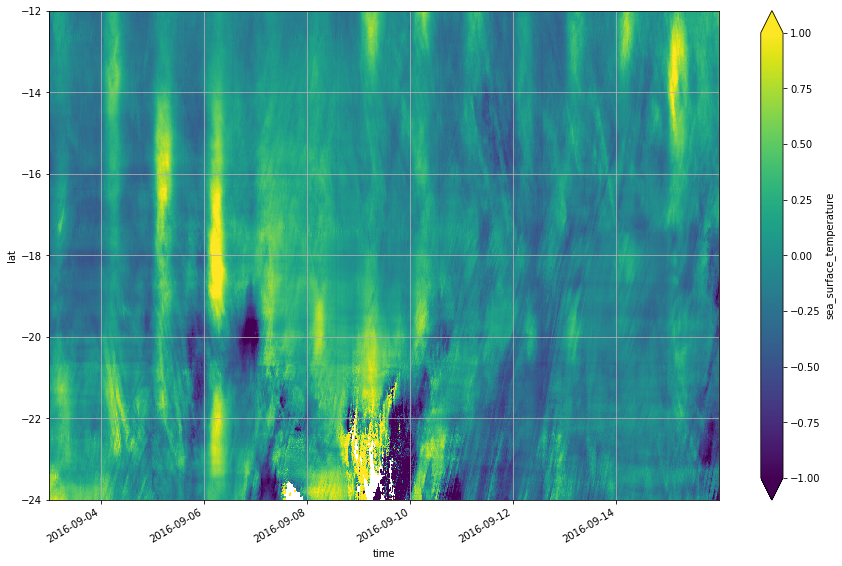

In [27]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
(ds['sea_surface_temperature'].mean('lon') - Tmean_xt).T.plot(ax=ax, vmin=-1., vmax=1.)
plt.grid()

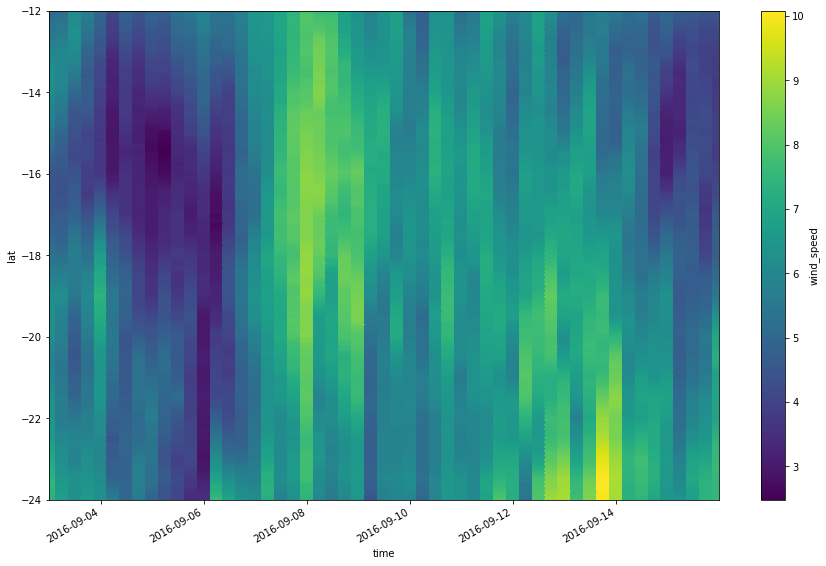

In [28]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
#ds['wind_speed'].mean('lon').T.plot(ax=ax, vmin=-1., vmax=1.)
ds['wind_speed'].mean('lon').T.plot(ax=ax)

---

# At single longitudes

In [29]:
T = ds['sea_surface_temperature'].sel(lon=116.,method='nearest')
T = T.sel(lat=slice(-15.,-21.5))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

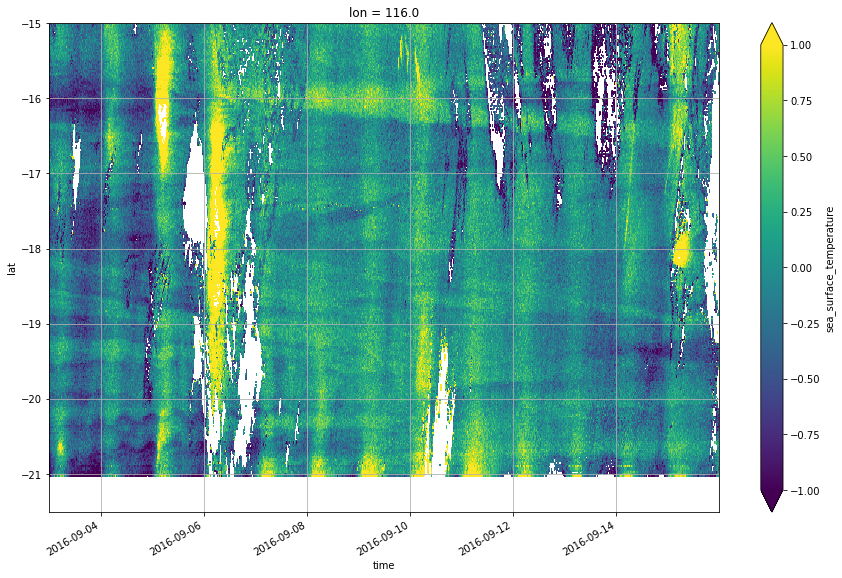

In [30]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()

In [31]:
T = ds['sea_surface_temperature'].sel(lon=120.,method='nearest')
T = T.sel(lat=slice(-12.,-20.))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

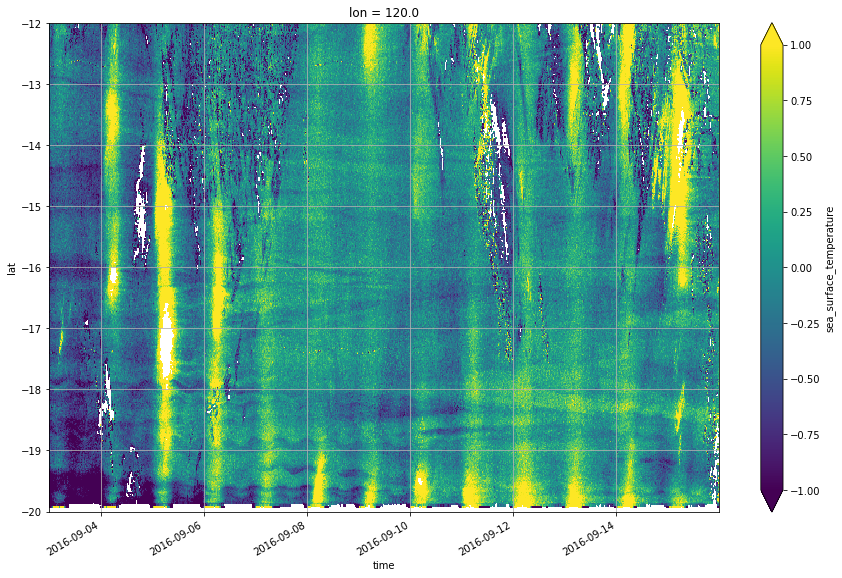

In [32]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()

---

# info, shutdown

In [33]:
client

Client Scheduler: tcp://10.148.1.112:43263 Dashboard: http://10.148.1.112:8787/status,Cluster Workers: 8 Cores: 112 Memory: 400.00 GB


In [ ]:
client.restart()

In [34]:
client.close()
cluster.stop_workers(cluster.jobs)